In [10]:
# allow interaction with the plots
%matplotlib widget

%load_ext autoreload
%autoreload 2

# add the main directory reference and import 'imports.py'
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")
from imports import *

logging.basicConfig(level=logging.ERROR)
__builtins__.verbosity = 5


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Declare a few global data/train params
class params:
    batch_size = 1024
    max_epochs = 300
    lr = 0.0001


data[-1] counts in label order from 0
Anaphase: 14
G1_G2_S: 28395
Metaphase: 61
Prophase: 545
Telophase: 24

Train Data (3 batches) Preview:
--------------------------------------------------
Constituent shapes:
batch[0]: torch.Size([8192, 3, 66, 66]), torch.float32
batch[1]: torch.Size([8192]), torch.int64

First 1 samples:

Sample 0: 

tensor([[[0.3961, 0.3961, 0.3961,  ..., 0.3843, 0.3843, 0.3843],
         [0.3961, 0.3961, 0.3961,  ..., 0.3843, 0.3843, 0.3843],
         [0.3961, 0.3961, 0.3961,  ..., 0.3843, 0.3843, 0.3843],
         ...,
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3647, 0.3647],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3647, 0.3647],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3647, 0.3647]],

        [[0.3961, 0.3961, 0.3961,  ..., 0.3843, 0.3843, 0.3843],
         [0.3961, 0.3961, 0.3961,  ..., 0.3843, 0.3843, 0.3843],
         [0.3961, 0.3961, 0.3961,  ..., 0.3843, 0.3843, 0.3843],
         ...,
         [0.4235, 0.4235, 0.4235,  ..., 0.364

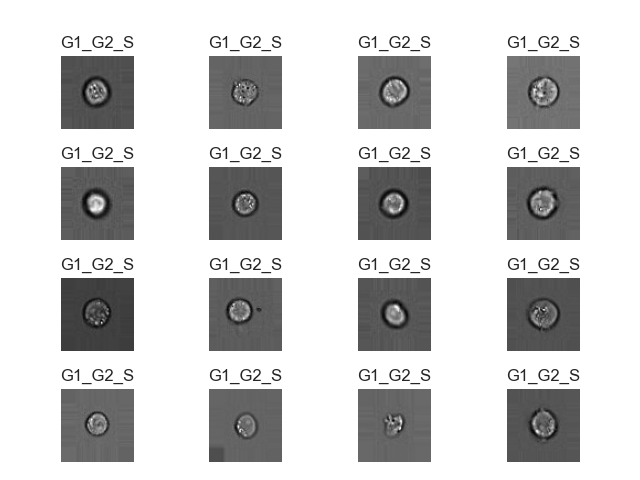

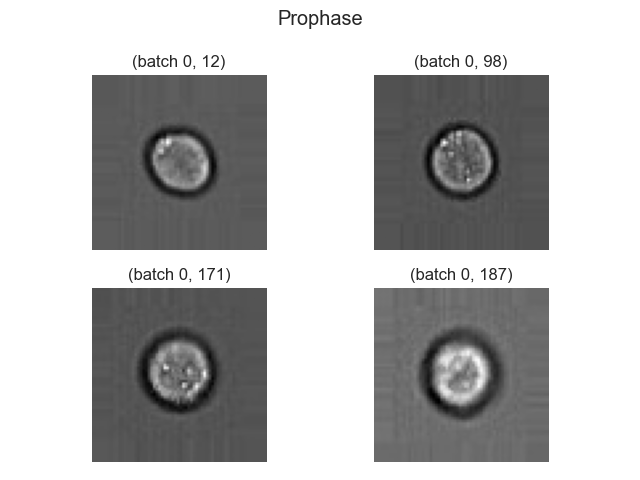

In [4]:
from data.CellCycle import Brightfield
from lib.data import *

plt.close("all")

# dt = Brightfield(batch_size=params.batch_size, num_workers=16)
dt = Brightfield(DataConfig.create(params))

dt.preview(samples=1)
sample = dt.sample_batch()
dt.visualize(*sample)
dt.visualize_class(3, samples=4)


For data preprocessing, we simply draw from the CellCycle dataset provided. As G_1, G_2, S are all Interphase, for the purposes of this experiment we combined them into one class.
Since all the images in the dataset were of the same resolution and similar quality, no extra preprocessing was needed.


However, the classes are massively imbalanced. We have several strategies to combat this:
- Resampling
- Augmentation
- One-vs-All


First, however, in order to evaluate our performance, we need some metrics that represent the under-sampled classes.
- Balanced/macro versions of Accuracy/Recall/F1 work well.
- Additionally, ROC and kappa can also be illuminating for unbalanced datasets.

kappa is nice because it accounts for the chance agreement, and thus if it is >0, it shows our model is not just predicting the one imbalanced class.

Any one of these above metrics or a combination thereof may be considered as an objective to optimize the performance and accuracy.

Below, we will plot Accuracy, Precision for both train and validation datasets. For validation, we will also plot kappa and recall.

Finally, we display the Confusion matrices.

If the results need improvement, we will try some of our strategies.

Below, we declare the metrics and the evaluation process.

In [12]:
from sklearn.metrics import cohen_kappa_score
from lib.metrics import *
import torcheval.metrics as ms


def init_metrics(flush_every):
    classification_val = MetricsFrame(
        [
            from_te(
                ms.MulticlassAccuracy,
                "Accuracy",
                average="macro",
                num_classes=dt.classes,
            ),
            from_te(
                ms.MulticlassPrecision,
                "Precision",
                average="macro",
                num_classes=dt.classes,
            ),
            CatMetric("kappa", cohen_kappa_score),
            from_te(
                ms.MulticlassRecall,
                "Recall",
                average="macro",
                num_classes=dt.classes,
            ),
        ],
        flush_every=flush_every,
    )

    classification_train = MetricsFrame(
        [
            from_te(
                ms.MulticlassAccuracy,
                "Accuracy",
                num_classes=dt.classes,
                average="macro",
            ),
            from_te(
                ms.MulticlassPrecision,
                "Precision",
                num_classes=dt.classes,
                average="macro",
            ),
        ],
        flush_every=flush_every,
    )

    ctrain_board = ProgressBoard(
        ylabel="Percent", title="Metrics (Train)", train_prefix=""
    )
    ctrain_board.add_mf(classification_train)
    cval_board = ProgressBoard(ylabel="Percent", title="Metrics (Validation)")
    cval_board.add_mf(classification_val)
    return {"train_mfs": [classification_train], "val_mfs": [classification_val]}


def eval_model(trainer):
    eval_ms = MetricsFrame(
        [
            from_te(
                ms.MulticlassConfusionMatrix,
                "ConfusionMatrix",
                num_classes=dt.classes,
            ),
            from_te(
                ms.MulticlassAccuracy,
                "Accuracy",
                average="macro",
                num_classes=dt.classes,
            ),
        ],
        flush_every=0,
        xlabel=None,
    )

    trainer.eval(
        pred=True,
        loss=True,
        mfs=eval_ms,
    )
    plot_2dheatmap(eval_ms.dict["ConfusionMatrix"][0])
    print(eval_ms.dict["Accuracy"])


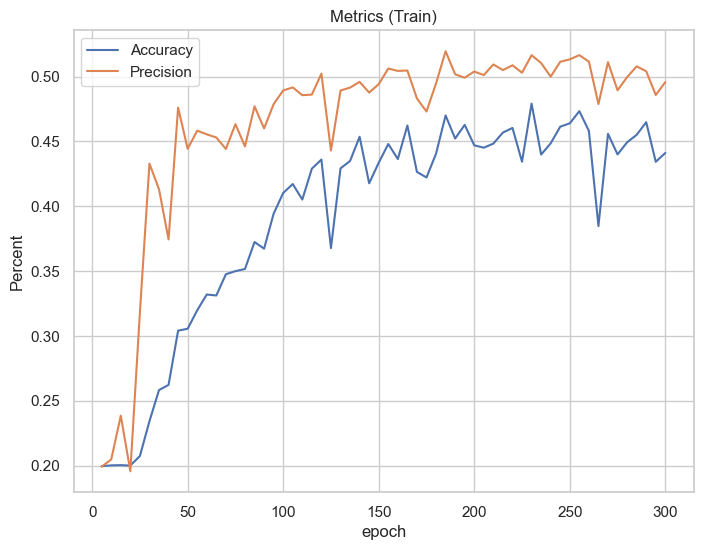

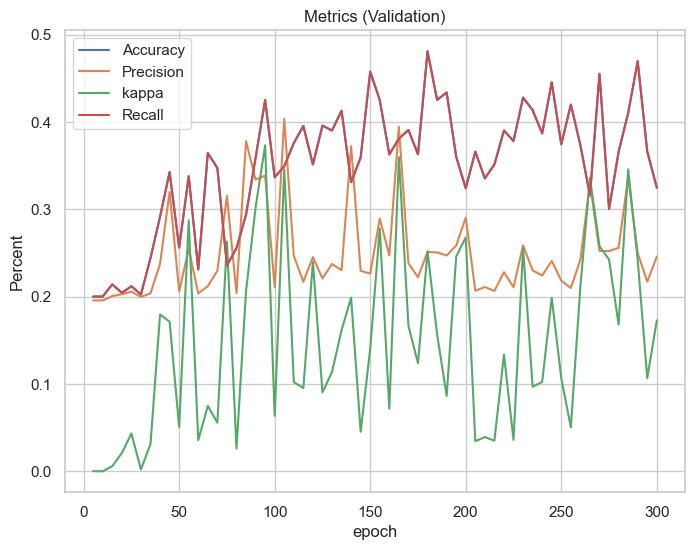

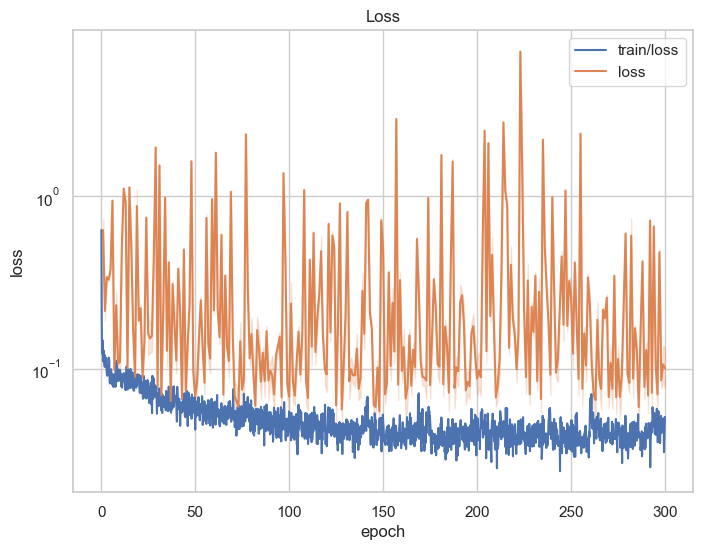

Epochs progress:   0%|          | 0/300 [00:00<?, ?Epoch/s]

tensor(0.0156, device='cuda:0')

In [15]:
from models.Convolution import *
from lib.train import *

plt.close("all")

cnn_config = CNNConfig(n_classes=dt.classes, n_blks=4, hidden_size=64)

model = CNN(cnn_config)

trainer = Trainer(TrainerConfig.create(params, **init_metrics(5)))
trainer.fit(model, dt.loaders())


0it [00:00, ?it/s]

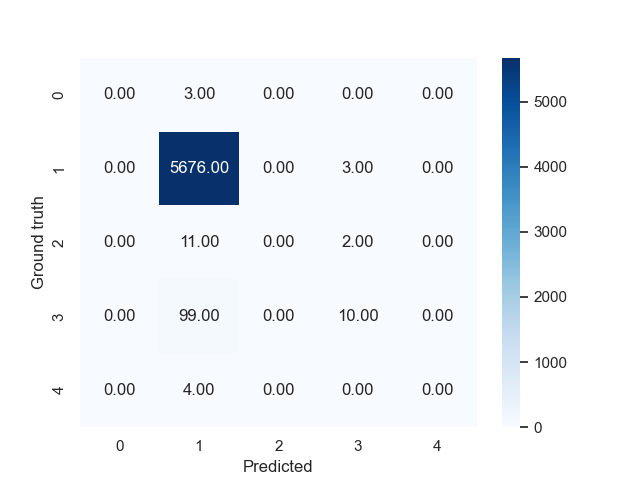

[0.21824298799037933]


In [ ]:
eval_model(trainer)


Our convolutional network consisted of an initial convolution followed by a maxpool of kernel size 2 which introduces some translational invariance. k=4 blocks follow. Each block starts with a (Bx)64xHxW convolution, followed by a batchnorm, ReLU and dropout.

An alternative approach could have been to have smaller convolutional layers but increase k, as that seems to be the more effective approach nowadays. We see that the model is able to predict the overabundant class well, but it is still confusing the others. Thus, we shall try data augmentation.Our convolutional network consists of an initial convolution followed by a maxpool of kernel size 2 which introduces some translational invariance. k=4 blocks follow. Each block starts with a (Bx)64xHxW convolution, followed by a batchnorm, ReLU and dropout.

An alternative approach could have been to have smaller convolutional layers but increase k, as that seems to be the more effective approach nowadays. We see that the model is able to predict the overabundant class well, but it is still confusing the others. Thus, we shall try data augmentation.

data[-1] counts in label order from 0
Anaphase: 14
G1_G2_S: 28395
Metaphase: 61
Prophase: 545
Telophase: 24

Train Data (3 batches) Preview:
--------------------------------------------------
Constituent shapes:
batch[0]: torch.Size([8192, 3, 66, 66]), torch.float32
batch[1]: torch.Size([8192]), torch.int64

First 1 samples:

Sample 0: 

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,

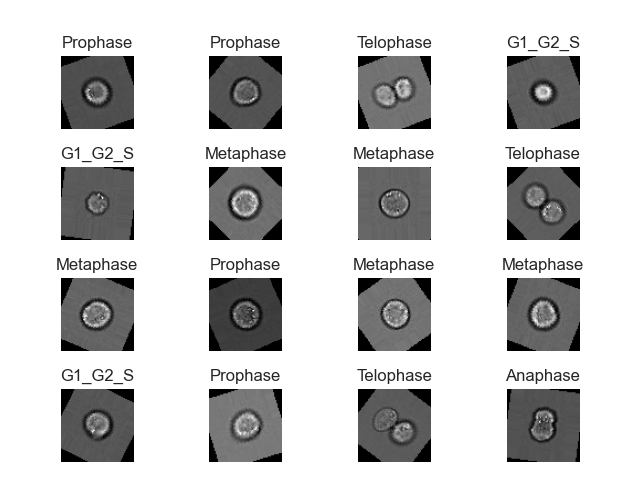

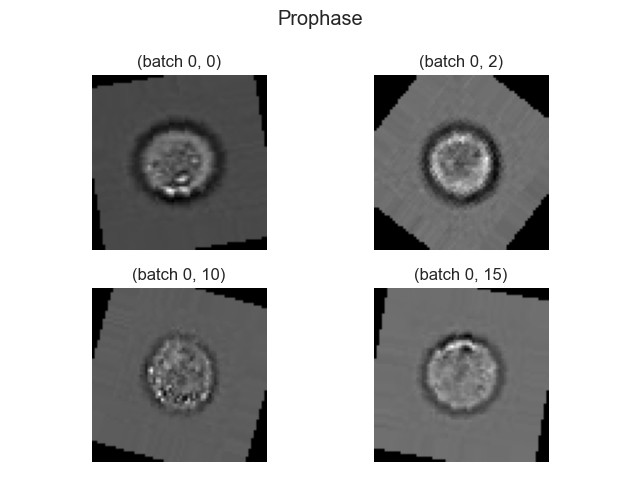

In [7]:
from data.CellCycle import *
from torchvision import transforms
from lib.data import *

plt.close("all")


# Declare a few global data/train params
class params:
    batch_size = 8192
    max_epochs = 300
    lr = 0.0001


transform = transforms.Compose(
    [
        # transforms.RandomResizedCrop(
        #     size=224, scale=(0.5, 1.0)
        # ),  # Random crop and resize
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=360),
        transforms.ToTensor(),
    ]
)

dt = Brightfield(
    DataConfig.create(
        params,
        sampler=ClassifierModule.make_inverse_sampler(factor=0.9),
        transform=transform,
    ),
)


dt.preview(samples=1)
sample = dt.sample_batch()
dt.visualize(*sample)
dt.visualize_class(3, samples=4)


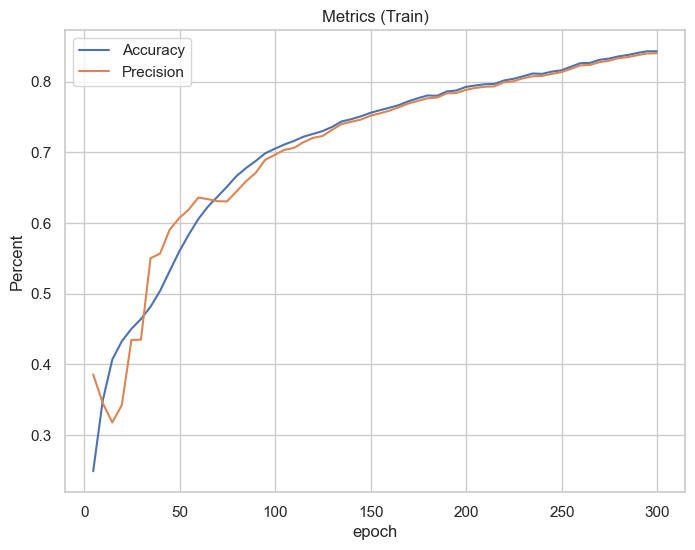

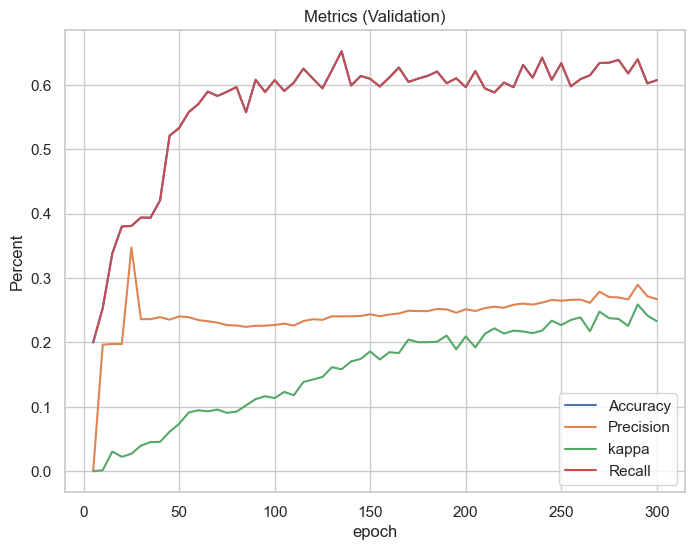

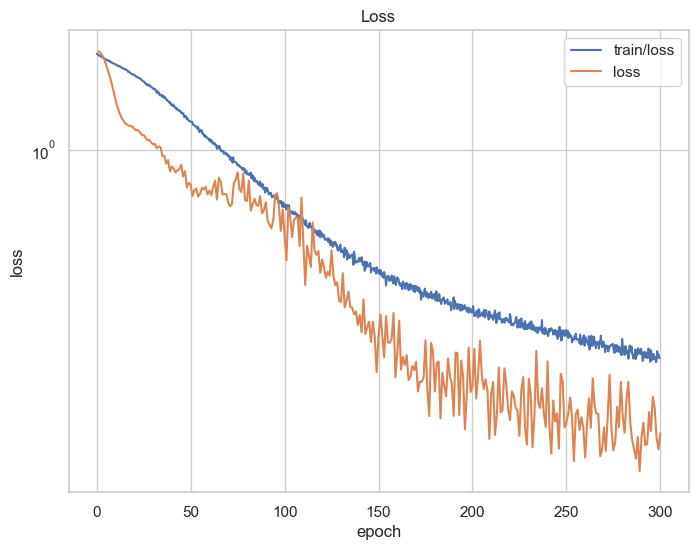

Epochs progress [Loss: 8.018e-02]: 100%|██████████| 300/300 [28:01<00:00,  5.61s/Epoch]


tensor(0.0663, device='cuda:0')

In [13]:
from models.Convolution import *
from lib.train import *

plt.close("all")

cnn_config = CNNConfig(n_classes=dt.classes, n_blks=4, hidden_size=64)

model = CNN(cnn_config)


trainer = Trainer(TrainerConfig.create(params, **init_metrics(5)))
trainer.fit(model, dt.loaders())


Validation loss is much better, and validation metrics improved as well.

More importantly, it looks like there is still room to grow with continued training, in particular, the imbalanced classes are much less a hindrance, as evidenced threefold by the good training accuracy, improving validation metrics, and the lower and stabler validation loss implying the model has learned to differentiate the classes.
    
One thing to note is that the validation dataset was augmented with transforms this time around so it's not the exact same comparison. Also, we trained for more epochs because it seemed more promising.

0it [00:00, ?it/s]

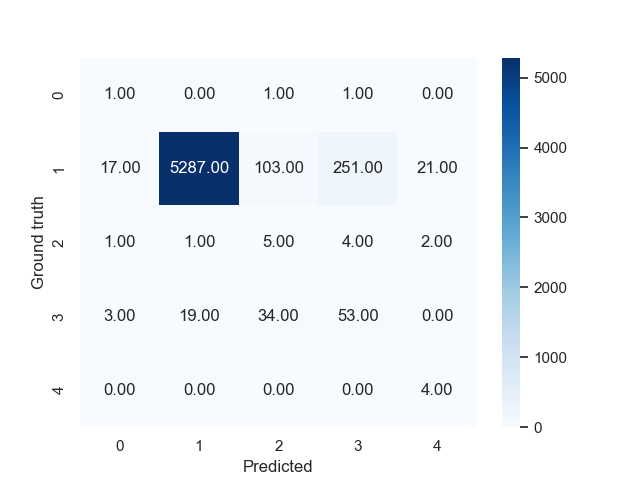

[0.6270322203636169]


In [14]:
eval_model(trainer)

A lot less false positives for class 1 but seems the model is still confusing class 3  (Prophase) and class 1 (Interphase). Understandable as they look quite similar. Maybe the added complexity of transforms require still more epochs? Nevertheless, most (in fact, all) metrics are improved.

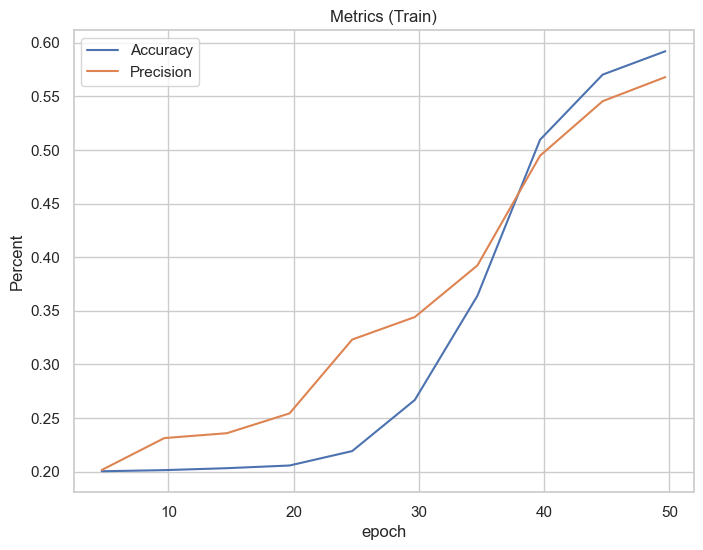

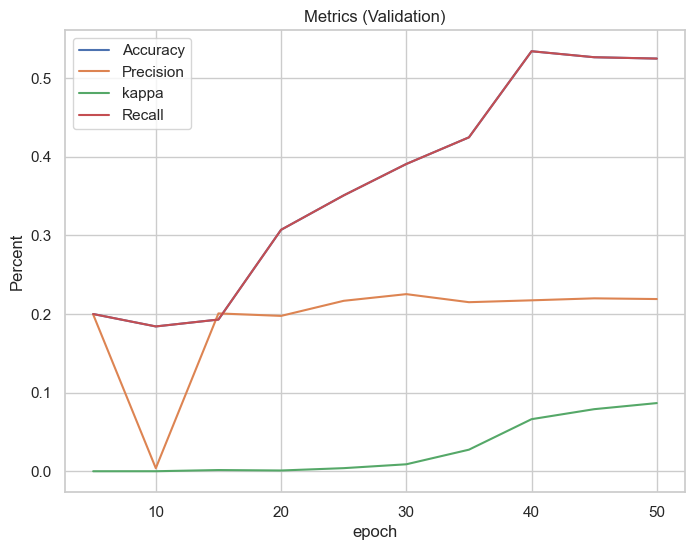

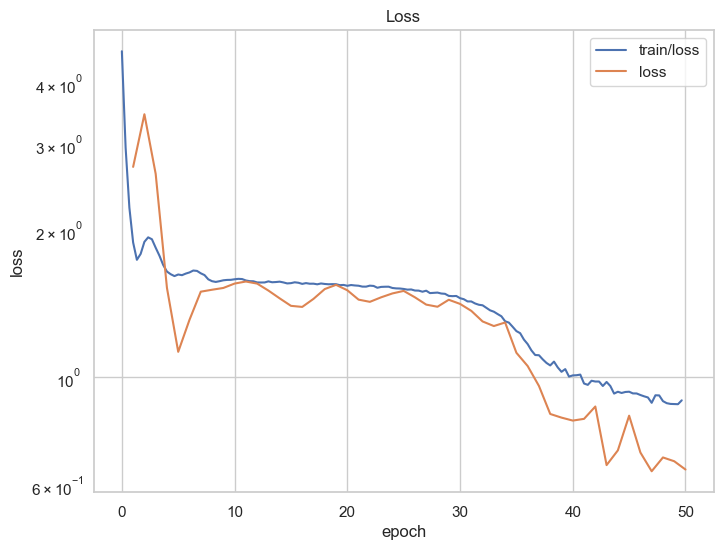

Epochs progress [Loss: 1.755e-01]:  17%|█▋        | 52/300 [05:12<24:44,  5.99s/Epoch]

In [ ]:
from models.ViT import *
from lib.metrics import *
from lib.train import *

plt.close("all")

sample_img = sample[0][0]

vit_config = ViTConfig(
    img_size=sample_img.shape[-1],
    patch_size=16,
    n_classes=dt.classes,
    n_blks=3,
    emb_size=512,
    n_heads=8,
    hidden_size=2048,
    class_freqs=torch.tensor([count for _, count in dt.counts], dtype=torch.float32),
)

model = ViT(vit_config)

trainer = Trainer(TrainerConfig.create(params, **init_metrics(5)))

trainer.fit(model, dt.loaders())


In [ ]:
sweep_configuration = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "minimize", "name": "loss"},
    "parameters": {
        "batch_size": {"values": [16, 32, 64]},
        "max_epochs": {"values": [5, 10, 15]},
        "lr": {"max": 0.1, "min": 0.0001},
    },
}


def tune(model, data, sweep_configuration=sweep_configuration):
    import wandb

    # Initialize sweep by passing in config.
    sweep_id = wandb.sweep(sweep=sweep_configuration, project=model.filename)

    def objective():
        run = wandb.init()  # noqa: F841

        trainer = Trainer(logger=wandb.log, **wandb.config)
        return trainer.fit(model, data)

    # Start sweep job.
    wandb.agent(sweep_id, function=objective, count=4)
